<div style="text-align: right"> David Diaz </div>
<div style="text-align: right"> 9/22/2017 </div>

## PhD Qualifying Exam, Question #4

The environment affects growth and mortality rates of trees. Three proximal planted stands of similar site productivity (as measured by site index) were observed over time (age) in intervals of two to eight years to produce these data. 

The following two mortality rate models have been proposed in the literature to model mortality empirically:  

[1] $ \frac{1}{N} \frac{dN}{dA} = \beta$  

[2] $ \frac{1}{N} \frac{dN}{dA} = \alpha A^\delta N^\phi$  

where $A$ = stand Age in years, $N$ = Number of surviving stems per acre, and $\alpha$, $\beta$, $\delta$, $\phi$ are parameters to be identified using some type of statistical tool (such as regression).

1. Fit each of these models to the data using regression. You may decide to integrate mathematically either or both equations and/or transform either or both the response & predictor variables to make the problem more tractable. Discuss the process and steps used in your modeling. This might include, but is not limited to: data considerations, considerations for transforming variables, evaluation of fit, etc. Choose and justify which is the “best” model for these data.
2. Discuss the limitations of your best model from both statistical and stand dynamics perspectives.
3. If data from many more stands were available for analysis, would any of the above parameters possibly contain a ‘random’ component (mixed modeling)? Would you expect any to be related to climatic or other environmental attributes?
4. List the assumptions necessary for your final model parameters to be “uniformly minimum–variance unbiased estimators” (UMVUE) and discuss how the ‘best’ model meets (or does not meet) each assumption and the potential impacts.

In [1]:
import numpy as np, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
# helper function to calculate differences in ages, tree count, and mortality rate
def calc_mort_rate(A, N):
    dA = [x2 - x1 for x1, x2 in zip(A, A[1:])]
    dN = [x2 - x1 for x1, x2 in zip(N, N[1:])]
    mort_rate = [dN/dA/N for dN, dA, N in zip(dN, dA, N[:-1])]
    # mort_rate can't be calculated at last observation, but we want to keep the other data in dataframe
    mort_rate.append(np.nan) # add an NA for the last observation
    return mort_rate

First, I'll create the data and put it into a pandas dataframe.

In [3]:
# stand 2
A = [2, 4, 6, 8, 10, 12, 16, 20, 24, 28]
N = [181, 175, 175, 175, 175, 175, 175, 175, 175, 172]
mort_rate = calc_mort_rate(A, N)
stand = [2]*len(mort_rate)
df = pd.DataFrame.from_items([('StandID', stand), ('Age', A), ('TPA', N), ('mort_rate', mort_rate)])

# stand 5
A = [2, 4, 6, 8, 10, 16, 24, 28]
N = [593, 585, 565, 552, 536, 516, 492, 456]
mort_rate = mort_rate = calc_mort_rate(A, N)
stand = [5]*len(mort_rate)
df = df.append(pd.DataFrame.from_items([('StandID', stand), ('Age', A), ('TPA', N), ('mort_rate', mort_rate)]), ignore_index=True)

# stand 6
A = [2, 4, 6, 8, 10, 16, 24, 28]
N = [986, 986, 981, 976, 967, 948, 901, 717]
mort_rate = mort_rate = calc_mort_rate(A, N)
stand = [6]*len(mort_rate)
df = df.append(pd.DataFrame.from_items([('StandID', stand), ('Age', A), ('TPA', N), ('mort_rate', mort_rate)]), ignore_index=True)

Here's what the data looks like for one of the stands (Stand 6):

In [4]:
df.loc[df.StandID == 6]

,StandID,Age,TPA,mort_rate
18,6,2,986,0.000000
19,6,4,986,-0.002535
20,6,6,981,-0.002548
21,6,8,976,-0.004611
22,6,10,967,-0.003275
23,6,16,948,-0.006197
24,6,24,901,-0.051054
25,6,28,717,NaN


Let's take a quick peak at how the data are correlated and distributed.

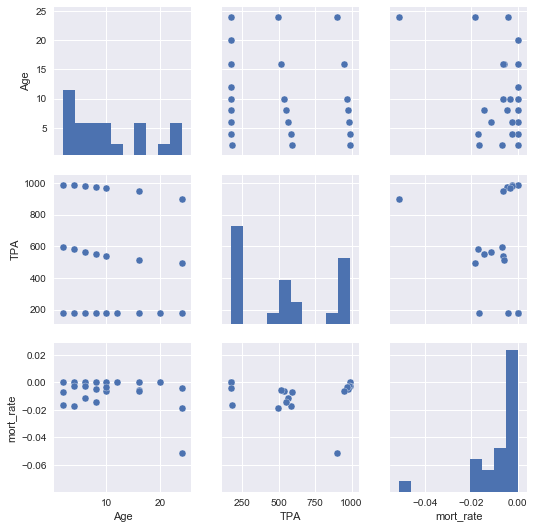

In [5]:
sns.pairplot(df[['Age', 'TPA', 'mort_rate']].dropna())
plt.show()

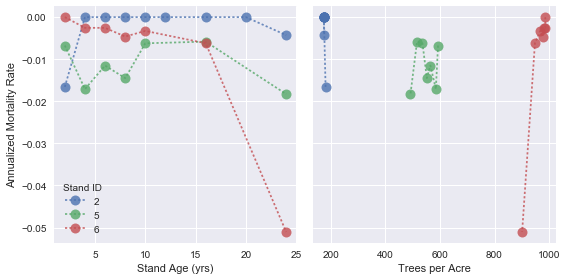

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4)) # create the plot to add data to
for standID, stand in df.groupby('StandID'): 
    # add the data for each stand to the plot
    ax1.plot(stand.Age, stand.mort_rate, marker='o', markersize=10, alpha=0.8, linestyle=':', label=standID)
    ax2.plot(stand.TPA, stand.mort_rate, marker='o', markersize=10, alpha=0.8, linestyle=':', label=standID)
ax1.legend(title='Stand ID')
ax1.set_xlabel('Stand Age (yrs)')
ax2.set_xlabel('Trees per Acre')
ax1.set_ylabel('Annualized Mortality Rate')
plt.tight_layout()

### Fitting the data
The `curve_fit` function from the python library scipy will fit a function to data using non-linear least squares optimization. I define the functions to fit here:

In [7]:
def eq1(x, beta):
    return beta
def eq2(x, alpha, delta, phi):
    return alpha * x.Age**delta * x.TPA**phi

In [8]:
df_fit = df.dropna() # curve_fit doesn't like NaNs in the data
Age = df_fit.Age
TPA = df_fit.TPA
Mort = df_fit.mort_rate
data_to_fit = df_fit[['Age', 'TPA']]

The `curve_fit` function returns the parameter estimates as well as the covariance of the parameters.  
Here I fit Equation 1 and report the parameter estimate for $\beta$, and the root mean square error (RMSE):

In [9]:
eq1_params, eq1_covar = curve_fit(eq1, xdata=data_to_fit, ydata=Mort)
print('Eq 1 parameter estimates:')
print('beta:', eq1_params[0])
print('RMSE:', np.sqrt(((eq1(data_to_fit, *eq1_params) - Mort) ** 2).mean()))

Eq 1 parameter estimates:
beta: -0.00744536290634
RMSE: 0.0110240307355


And here I fit Equation 2 and report the parameter estimates and RMSE:

In [10]:
eq2_params, eq2_covar = curve_fit(eq2, xdata=df_fit[['Age', 'TPA']], ydata=df_fit['mort_rate'])
print('Eq 2 parameter estimates:')
for name, value in zip(['alpha:', 'delta:', 'phi:'], eq2_params):
    print(name, value)
print('RMSE:', np.sqrt(((eq2(data_to_fit, *eq2_params) - Mort) ** 2).mean()))

Eq 2 parameter estimates:
alpha: -1.64934780619e-12
delta: 4.14916074312
phi: 1.6103785477
RMSE: 0.0067021750841


Let's take a look at what the predictions look like.

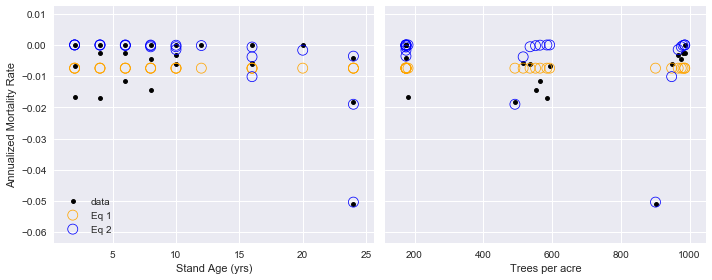

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))

# plot the raw data, equations 1, and 2 for Mort(Y) vs. Age(X)
ax1.scatter(Age, Mort, label='data', color='black', linewidth=1, s=15)
ax1.scatter(Age, [eq1(data_to_fit, *eq1_params)]*len(Age), facecolors='none', 
            edgecolors='orange', linewidth=0.75, s=100, label='Eq 1')
ax1.scatter(Age, eq2(data_to_fit, *eq2_params), facecolors='none', 
            edgecolors='blue', linewidth=0.75, s=100, label='Eq 2')

# plot the raw data, equations 1, and 2 for Mort(Y) vs. TPA(X)
ax2.scatter(TPA, Mort, label='data', color='black', linewidth=1, s=15)
ax2.scatter(TPA, [eq1(data_to_fit, *eq1_params)]*len(df_fit.Age), facecolors='none', 
            edgecolors='orange', linewidth=0.75, s=100, label='Eq 1')
ax2.scatter(TPA, eq2(data_to_fit, *eq2_params), facecolors='none',
            edgecolors='blue', linewidth=0.75, s=100, label='Eq 2')

# format the graph
ax1.legend(loc='lower left')
ax1.set_ylabel('Annualized Mortality Rate')
ax1.set_xlabel('Stand Age (yrs)')
ax2.set_xlabel('Trees per acre')
plt.tight_layout()

### Model interpretation and limitations
Model 1 is insensitive to any stand conditions; it ignores stand dynamics entirely. It treats annual mortality in diverse stands as a constant rate, $\beta$.  

Model 2 adds information about current stand conditions into the model. It implies all stands will express annual mortality the same way, but allows the mortality rate to vary as a function of stem density and age. The use of exponential forms for parameters $\delta$ and $\phi$ allows there to be a continuous change in the effect of current age and current stem density over time, respectively. 

Both models assume that all the observations of mortality rates are independent and identically distributed (iid). It seems plausible, for example, that mortality rates might display temporal autocorrelation. The inclusion of a lag term, allowing the observed mortality rate from a previous period to affect the current period would be a way to incorporate this type of behavior.

Among these two choices, I would prefer Model 2 because it accomodates more sensible ecological interpretation. Statistically, it also provides a better fit as judged by a smaller RMSE. 

I will also admit here that if I had more time to figure out how to do this, I would have preferred to have modeled the mortality rate as a beta-distributed random variable considering it is confined to the range[0,1]. I experimented with some transformations of the mortality rate, which was challenging due to the fact that many zeros are present. It is also apparent from the pairwise plots and histograms at the start of data exploration that TPA in particular is not normally distributed among the samples. A log-transformation of age would've seemed sensible, but didn't produce substantial changes in my curve-fitting outcomes. It is not clear to met whether any reasonable transformation of TPA would make it more normal.

### If more stands were in the mix
If staying within a Frequentist approach, I would keep the effects of age ($A$) and tpa ($N$) as fixed effects, and add a random component for each stand. This would take the form of an index on whichever model parameters I wanted to allow to vary among stands (e.g., adding an index $s$ to represent each stand out of $S$ total stands, $\beta_s$ in Equation 1 would allow the annualized mortality rate to be calculated separately for each stand). In Equation 2, I could experiment with allowing some parameters to remain fixed (implying they remain constant across all stands). 

If I wanted to incorporate climatic effects, I would do so by adding a climate-related variable to the model that would modify the effect of stand density. This is based on the expectation that competition, using trees per acre as an indicator, would influence a stand's reaction to available resources (e.g., water). I would not incorporate a similar modifier for stand age, because I would not expect an interaction between stand age and climate. 

### Assumptions regearding UMVUE
A quick reading through the Wikipedia descriptions of [uniformly minimum–variance unbiased estimators](https://en.wikipedia.org/wiki/Minimum-variance_unbiased_estimator) and the [Lehmann–Scheffé theorem](https://en.wikipedia.org/wiki/Lehmann%E2%80%93Scheff%C3%A9_theorem) offered the insights that a statistic which is complete and sufficient to describe the parameter being estimated is the UMVUE. That is, the parameter estimates 

It is not immediately clear whether the parameters in these models would best be represented with normal distributions. If that is indeed the case, then the mean parameter estimates and standard deviation that could be derived from the covariance table produced by the least squares optimization could offer UMVUEs of these model parameters. If instead these parameters are not well described by normal distributions, which I would suspect to be the case, then the model parameters I've estimated would not be UMVUEs.